# Solitaire Win Streaks

Over the last year or so, I have been playing a lot of solitaire (using an app on my phone).  I have noticed that I tend to win games in streaks.  I will win 5-10 games in a row, then lose a few, then win a few more.  I have always wondered if this is just a coincidence or if there is some underlying reason for this.  I decided to investigate this using a simple simulation.

Here are my "stats" from the app:

- Total games played:  2571
- Total games won:  1721
- Win percentage:  66.94%
- Longest win streak:  33

Strategy:

Simulate a sequence of 2500 games of solitaire, where the win percentage is varied from 0.5 to 1.0.  For each win percentage, calculate the average number of consecutive wins and the maximum number of consecutive wins.  Repeat this simulation 10000 times to get an average and standard deviation for the average and maximum number of consecutive wins for each win percentage.

Once we have this data set, we can plot the average and maximum number of consecutive wins as a function of win percentage.  We can also fit a curve to the data to see if there is a relationship between win percentage and average number of consecutive wins.

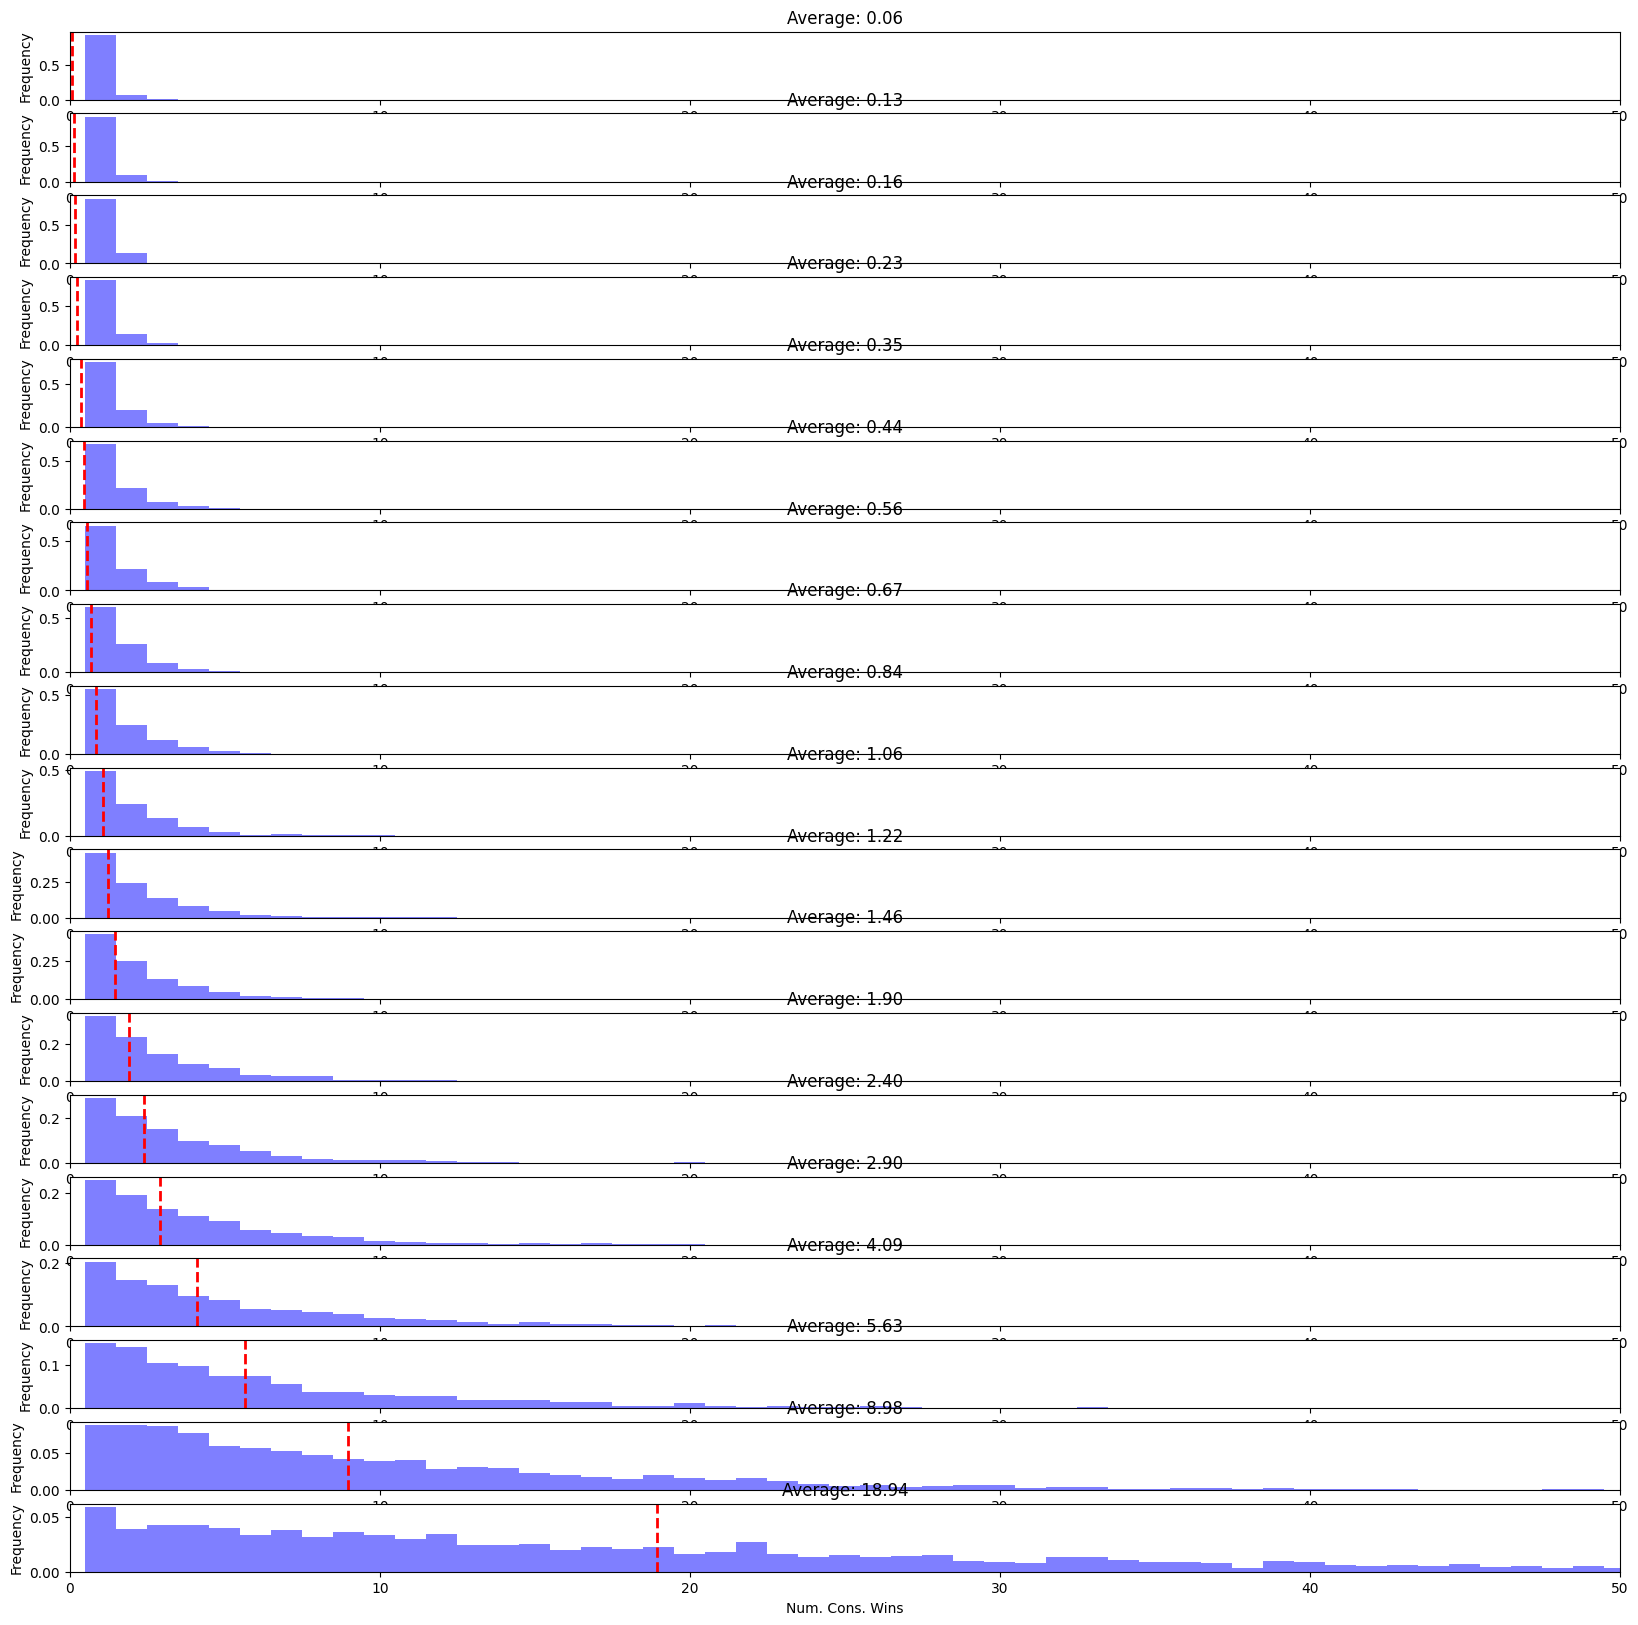

In [1]:
import numpy as np
import matplotlib.pyplot as plt

ngames = 2500

win_percentage = [0.05*i for i in range(1, 20)]

# Play a game until a loss and record number of consecutive wins
def play_game(wp):
    wins = 0
    while np.random.rand() < wp:
        wins += 1
    return wins

def play_set_of_games(win_percentage, ngames, do_plot=False):
    
    #print('Playing {} games for each win percentage'.format(ngames))
    #print('Win percentages: ', win_percentage)

    plot_number = 0
    avg_wins = []
    max_wins = []
    
    if (do_plot):
        fig, ax = plt.subplots(19, 1, figsize=(20, 20))
        
    for wp in win_percentage:
        # Simulate many games
        wins = [play_game(wp) for _ in range(ngames)]


        # Calculate average number of consecutive wins
        average_wins = np.mean(wins)
        avg_wins.append(average_wins)
        max_wins.append(np.max(wins))
        
        if do_plot:
            
            # create a histogram of the number of consecutive wins
            wins_hist = np.histogram(wins, bins=range(1, max(wins)+2), density=True)
            # Plot histogram of number of consecutive wins
            ax[plot_number].bar(wins_hist[1][:-1], wins_hist[0], width=1.0, color='blue', alpha=0.5)
            ax[plot_number].axvline(average_wins, color='red', linestyle='dashed', linewidth=2)
            ax[plot_number].set_xlabel('Num. Cons. Wins')
            ax[plot_number].set_ylabel('Frequency')
            ax[plot_number].set_title('Average: {:.2f}'.format(average_wins))
            ax[plot_number].set_xlim([0, 50])
        
        plot_number += 1
    
    return avg_wins, max_wins
    
avg_wins, max_wins = play_set_of_games(win_percentage, ngames, do_plot=True)

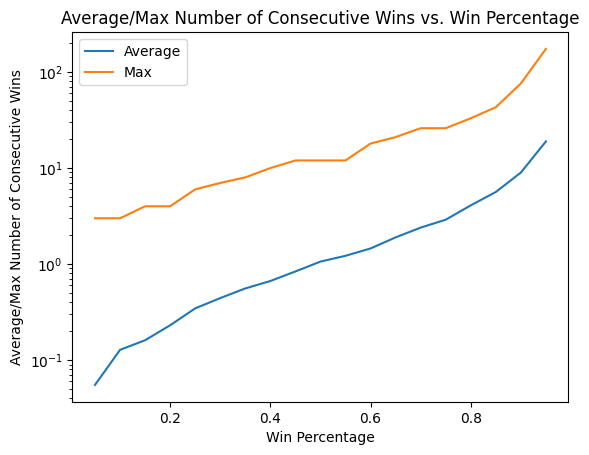

In [2]:
plt.plot(win_percentage, avg_wins, label='Average')
plt.plot(win_percentage, max_wins, label='Max')
plt.xlabel('Win Percentage')
plt.ylabel('Average/Max Number of Consecutive Wins')
plt.title('Average/Max Number of Consecutive Wins vs. Win Percentage')
plt.yscale('log')
plt.legend()

In [3]:
nsets = 10000

avg_wins_sets = np.zeros((nsets, len(win_percentage)))
max_wins_sets = np.zeros((nsets, len(win_percentage)))

for i in range(nsets):
    avg_wins, max_wins = play_set_of_games(win_percentage, ngames)
    avg_wins_sets[i] = avg_wins
    max_wins_sets[i] = max_wins

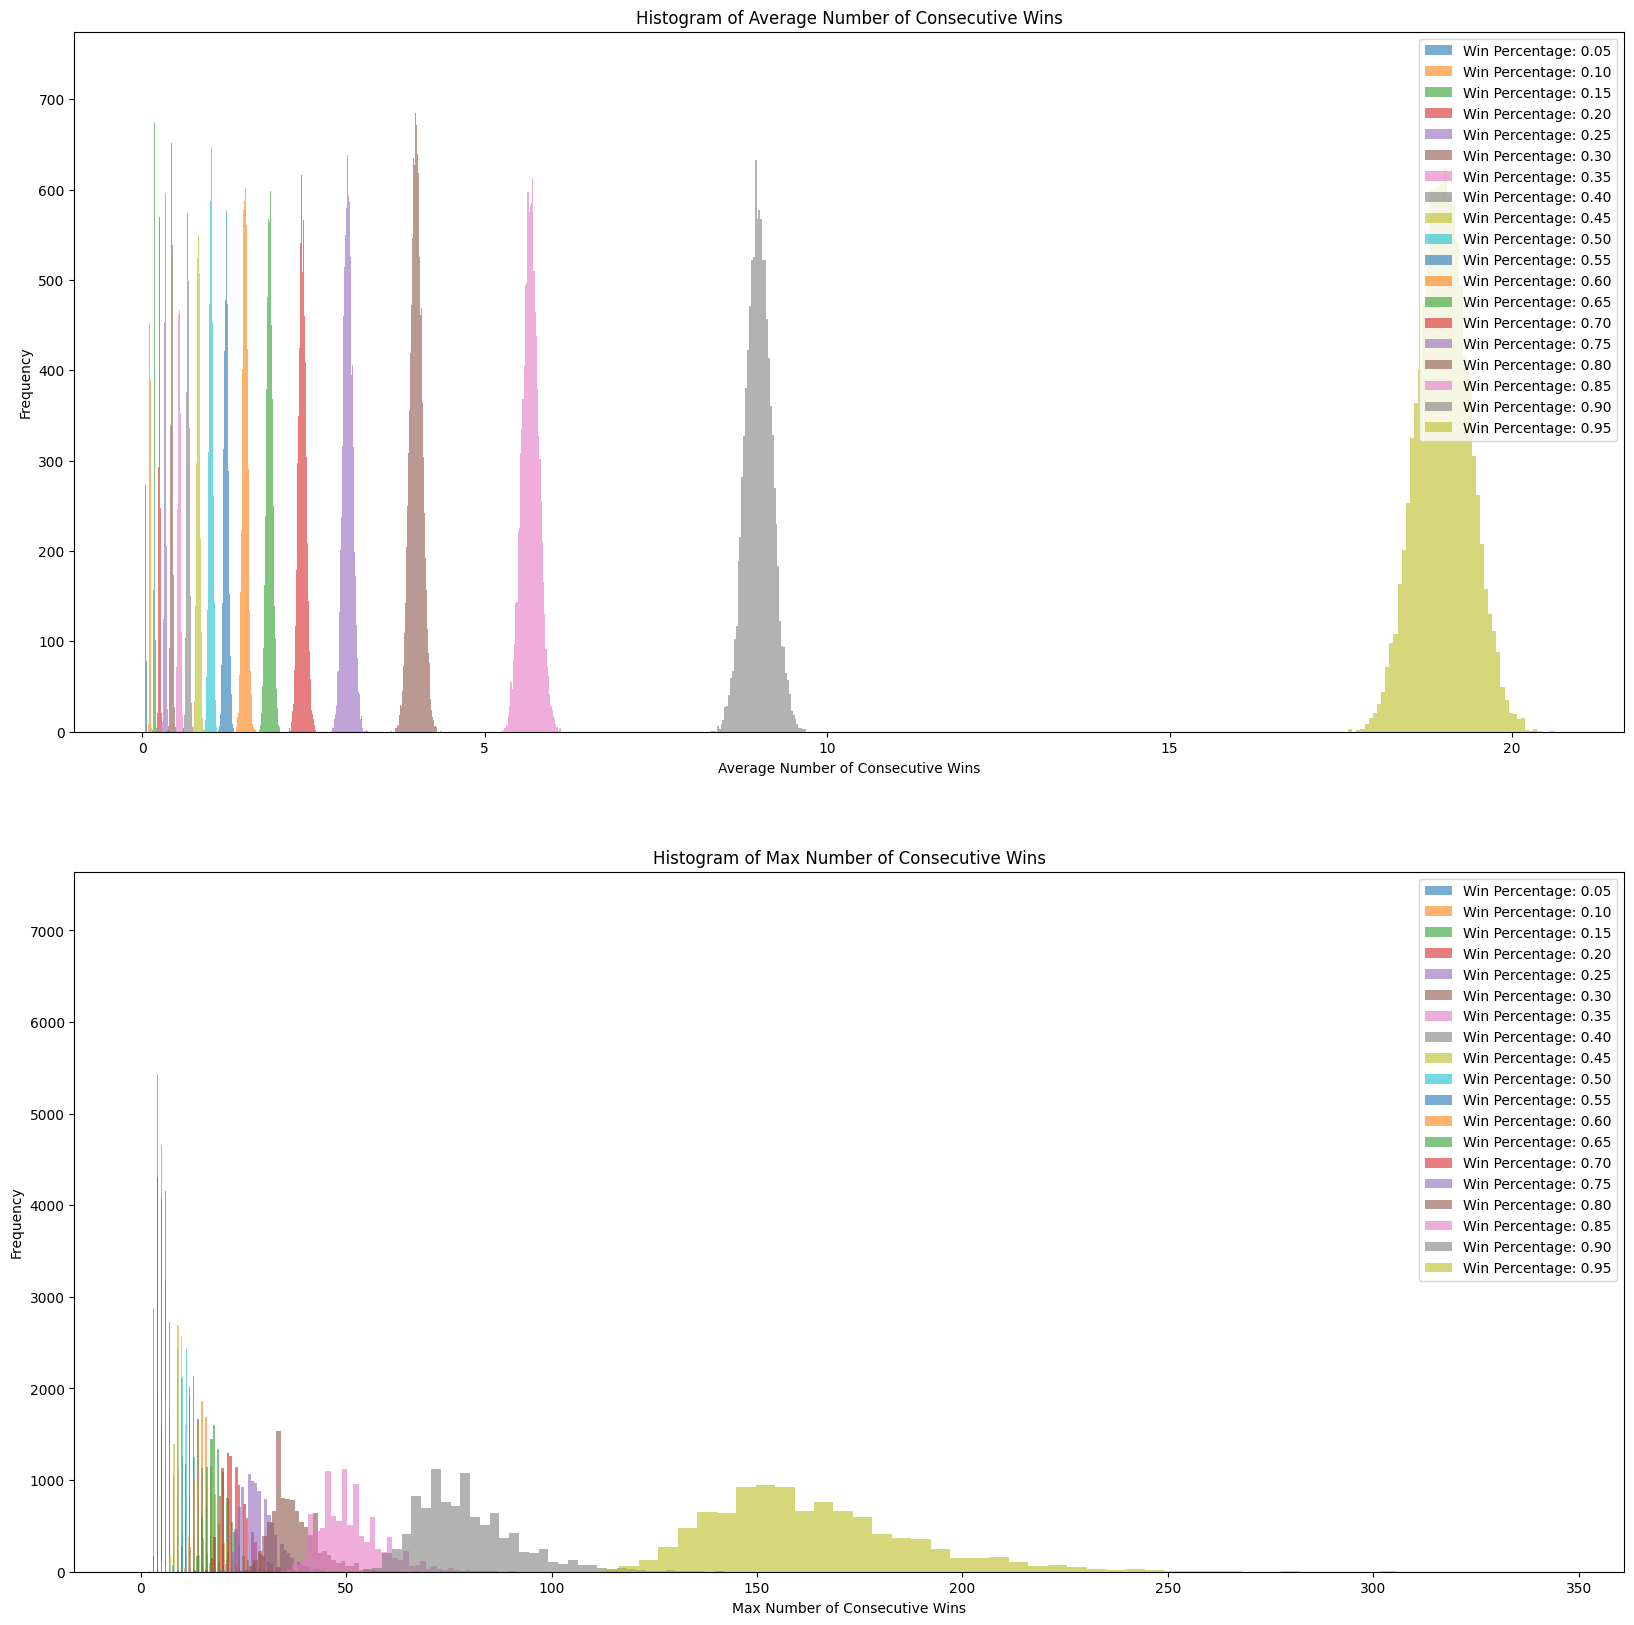

In [4]:
# Create a histogram of the average number of consecutive wins and max wins for a specified win percentage

fig, ax = plt.subplots(2, 1, figsize=(20, 20))

for i in range(len(win_percentage)):
    ax[0].hist(avg_wins_sets[:, i], bins=50, alpha=0.6, label='Win Percentage: {:.2f}'.format(win_percentage[i]))
    ax[1].hist(max_wins_sets[:, i], bins=50, alpha=0.6, label='Win Percentage: {:.2f}'.format(win_percentage[i]))
    
ax[0].set_xlabel('Average Number of Consecutive Wins')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Average Number of Consecutive Wins')
ax[0].legend()

ax[1].set_xlabel('Max Number of Consecutive Wins')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Max Number of Consecutive Wins')
ax[1].legend()

Fit parameters:  [ 508.31000945 -615.21934587  255.20239883  -21.66419584    2.98695145]
Parameter errors:  [160.88646989 254.70435468 130.76365577  24.36018529   1.26919867]


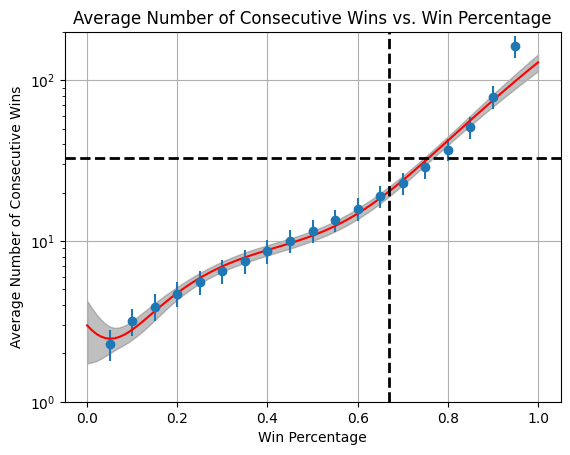

In [5]:
centroid = []
stdev = []
for i in range(len(win_percentage)):
    centroid.append(max_wins_sets[:,i].mean())
    stdev.append(max_wins_sets[:,i].std())

plt.errorbar(win_percentage, centroid, yerr=stdev, fmt='o')
plt.xlabel('Win Percentage')
plt.ylabel('Average Number of Consecutive Wins')
plt.title('Average Number of Consecutive Wins vs. Win Percentage')
plt.grid()

from scipy.optimize import curve_fit

def func(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e
init_params = [1, 1, 1, 1, 1]
popt, pcov = curve_fit(func, win_percentage, centroid, p0=init_params, absolute_sigma=True, sigma=stdev)

xfit = np.linspace(0.0, 1.0, 100)

plt.plot(xfit, func(xfit, *popt), 'r-')
ps = np.random.multivariate_normal(popt, pcov, 10000)
ysample=np.asarray([func(xfit, *pi) for pi in ps])
lower = np.percentile(ysample, 16.0, axis=0)
upper = np.percentile(ysample, 84.0, axis=0)

plt.fill_between(xfit, lower, upper, color='gray', alpha=0.5)

plt.ylim(1, 200)
# plot a horizontal line at y=33
plt.axhline(33, color='black', linestyle='dashed', linewidth=2)

# plot a vertical line at x=0.6675
plt.axvline(0.6694, color='black', linestyle='dashed', linewidth=2)
plt.yscale('log')

perr = np.sqrt(np.diag(pcov))
print('Fit parameters: ', popt)
print('Parameter errors: ', perr)
